<a href="https://colab.research.google.com/github/jeshmin-shrestha/Mental-Health-Classification/blob/main/Mental_Health_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health Classfication

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
nltk.download(['punkt', 'stopwords', 'wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Load dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/AML/23048596 Jeshmin Shrestha/sentiment-analysis-for-mental-health.csv')
df

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 3 columns]

In [ ]:
df["status"].value_counts(normalize=True)

status
Normal                  0.308259
Depression              0.290406
Suicidal                0.200837
Anxiety                 0.073299
Bipolar                 0.054239
Stress                  0.050318
Personality disorder    0.022642
Name: proportion, dtype: float64

In [ ]:
print(f"Dataset shape: {df.shape}")


Dataset shape: (53043, 3)


In [ ]:
# Display basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (53043, 3)
Dataset columns: ['Unnamed: 0', 'statement', 'status']

First 5 rows:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [ ]:
# Display dataset information
print("\nDataset Information:")
print(df.info())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [ ]:
# Check for missing values
print("\nMissing Values Analysis:")
missing_values = df.isnull().sum()
print(missing_values)


Missing Values Analysis:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [ ]:
#Remove unnecessary column
df = df.drop(columns=['Unnamed: 0'])
print(f"After removing 'Unnamed: 0': {df.shape}")
print(f"Current columns: {df.columns.tolist()}")

After removing 'Unnamed: 0': (53043, 2)
Current columns: ['statement', 'status']


In [ ]:
# Remove null or missing values
df_clean = df.dropna()
print(f"Clean dataset: {df_clean.shape[0]} rows")

Clean dataset: 52681 rows


In [ ]:
# Check for duplicate rows
duplicate_count = df_clean.duplicated().sum()
print(f"\nDuplicate Records Analysis:")
print(f"Number of duplicate rows: {duplicate_count}")


Duplicate Records Analysis:
Number of duplicate rows: 1588


In [ ]:
# Unique labels in status column
print("\nUnique labels in 'status' column:")
unique_labels = df['status'].unique()
print(f"Count: {len(unique_labels)} labels")
print(f"Labels: {unique_labels}")


Unique labels in 'status' column:
Count: 7 labels
Labels: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


In [ ]:
print("\n Distribution of labels:")
label_counts = df['status'].value_counts()
print(label_counts)


 Distribution of labels:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


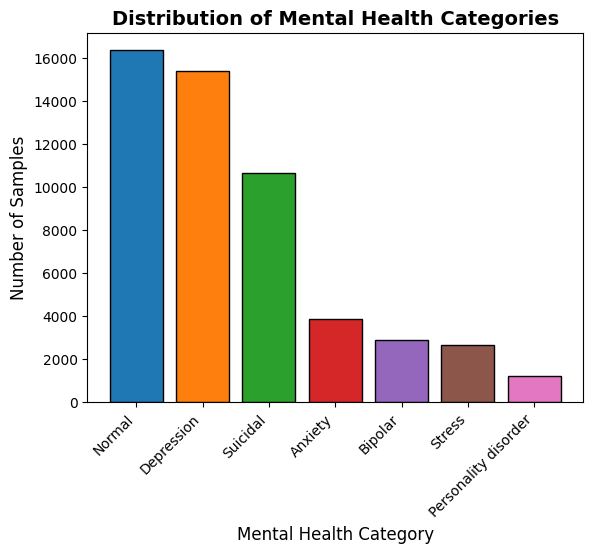

In [ ]:
bars = plt.bar(label_counts.index, label_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                      '#9467bd', '#8c564b', '#e377c2'],
               edgecolor='black')

plt.title('Distribution of Mental Health Categories', fontsize=14, fontweight='bold')
plt.xlabel('Mental Health Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
!pip install emoji
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.6 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries for Text preprocessing
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Define Stopwords
stop_words = set(stopwords.words('english'))
# Define Lemmatizer
lemmatizer = WordNetLemmatizer()


In [ ]:
#=====ATTEMPT1======
def preprocess_text_v1(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)



In [ ]:
#=====ATTEMPT2======
def preprocess_text_v2(text):
    if not isinstance(text, str):
        return ""

    #  Expand contractions
    text = contractions.fix(text)

    #  Convert to lowercase
    text = text.lower()

    #  Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)

    #  Remove emojis
    text = emoji.replace_emoji(text, replace='')

    #  Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #  Tokenize
    tokens = word_tokenize(text)

    #  Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    #  Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #  Rejoin tokens
    clean_text = ' '.join(tokens)

    return clean_text

In [ ]:
df['clean_text'] = df['statement'].apply(preprocess_text_v2)

# Check sample
df[['statement', 'clean_text']].head()


statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                          clean_text  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3         shifted focus something else still worried  
4                   restless restless month boy mean

In [ ]:
def get_vocabulary(series):
    all_words = []
    for text in series:
        if pd.notna(text):
            words = str(text).split()
            all_words.extend(words)
    return set(all_words)

original_vocab = get_vocabulary(df['statement'])
cleaned_vocab = get_vocabulary(df['clean_text'])

print(f"Original vocabulary size: {len(original_vocab):,} unique words")
print(f"Cleaned vocabulary size: {len(cleaned_vocab):,} unique words")
print(f"Vocabulary reduction: {((len(original_vocab)-len(cleaned_vocab))/len(original_vocab)*100):.1f}%")

Original vocabulary size: 154,767 unique words
Cleaned vocabulary size: 68,064 unique words
Vocabulary reduction: 56.0%


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split dataset into features and labels
X = df['clean_text']
y = df['status']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit features to 5000 to reduce complexity
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results:
                      precision    recall  f1-score   support

             Anxiety       0.74      0.78      0.76       778
             Bipolar       0.66      0.77      0.71       575
          Depression       0.77      0.56      0.65      3081
              Normal       0.87      0.88      0.88      3270
Personality disorder       0.30      0.66      0.42       240
              Stress       0.40      0.63      0.49       534
            Suicidal       0.65      0.68      0.66      2131

            accuracy                           0.72     10609
           macro avg       0.63      0.71      0.65     10609
        weighted avg       0.74      0.72      0.72     10609

[[ 608   25   27   40   13   59    6]
 [  12  443   38   31   19   19   13]
 [  95  127 1718  137  158  179  667]
 [  31   18   46 2888   72  147   68]
 [   6    2   22   31  158   15    6]
 [  48   16   43   39   30  335   23]
 [  21   36  343  141   71   78 1441]]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate metrics for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_macro_f1 = f1_score(y_test, y_pred_lr, average='macro')
lr_weighted_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression - Attempt 1")
print(f"Accuracy: {lr_accuracy:.3f}")
print(f"Macro Average F1-score: {lr_macro_f1:.3f}")
print(f"Weighted Average F1-score: {lr_weighted_f1:.3f}")

Logistic Regression - Attempt 1
Accuracy: 0.716
Macro Average F1-score: 0.652
Weighted Average F1-score: 0.720


In [ ]:
# SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

SVM Results:
                      precision    recall  f1-score   support

             Anxiety       0.72      0.79      0.75       778
             Bipolar       0.67      0.77      0.72       575
          Depression       0.76      0.57      0.65      3081
              Normal       0.87      0.91      0.89      3270
Personality disorder       0.37      0.59      0.45       240
              Stress       0.44      0.57      0.50       534
            Suicidal       0.64      0.69      0.67      2131

            accuracy                           0.73     10609
           macro avg       0.64      0.70      0.66     10609
        weighted avg       0.74      0.73      0.73     10609

[[ 612   24   25   46    5   58    8]
 [  16  443   46   29    8   16   17]
 [ 114  111 1751  146  113  138  708]
 [  26   28   40 2969   43  112   52]
 [   7    5   31   34  141   14    8]
 [  58   22   58   48   23  307   18]
 [  20   31  359  140   52   58 1471]]


In [ ]:
# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_macro_f1 = f1_score(y_test, y_pred_svm, average='macro')
svm_weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f"\nSVM - Attempt 1")
print(f"Accuracy: {svm_accuracy:.3f}")
print(f"Macro Average F1-score: {svm_macro_f1:.3f}")
print(f"Weighted Average F1-score: {svm_weighted_f1:.3f}")


SVM - Attempt 1
Accuracy: 0.725
Macro Average F1-score: 0.660
Weighted Average F1-score: 0.725



COMPARISON TABLE
              Model  Accuracy  Macro F1  Weighted F1
Logistic Regression    0.7155    0.6522       0.7198
         Linear SVM    0.7252    0.6597       0.7255


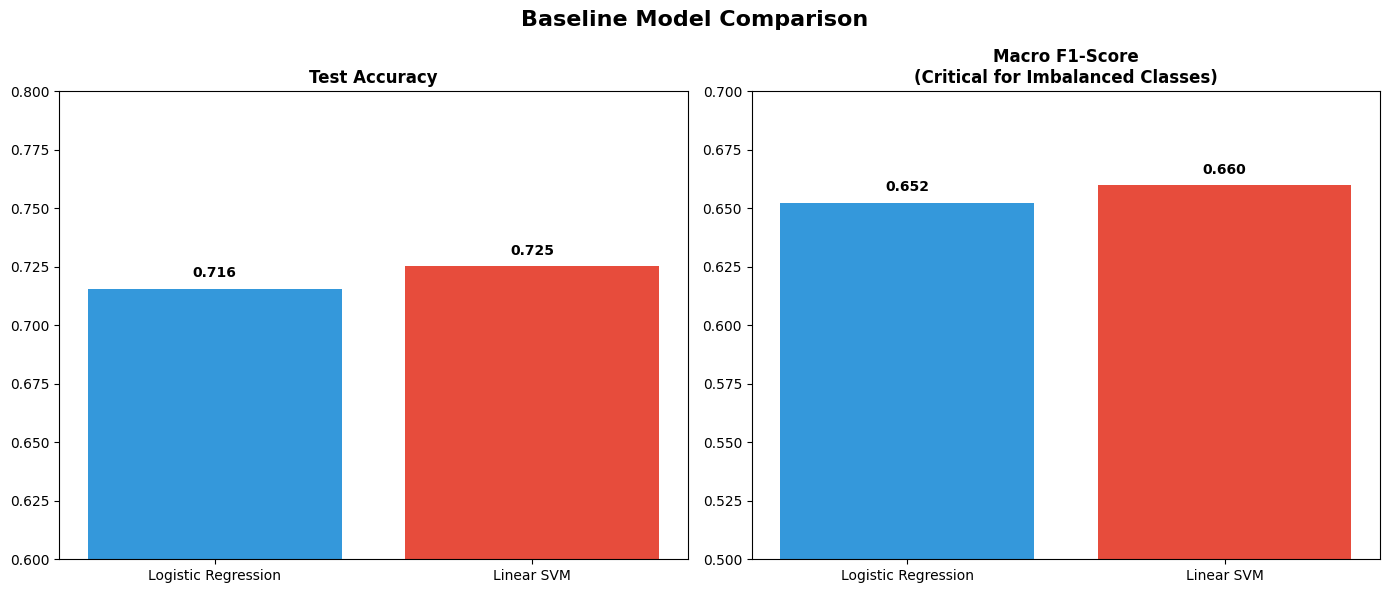

In [ ]:
# Comparison DataFrame
comparison_data = {
    'Model': ['Logistic Regression', 'Linear SVM'],
    'Accuracy': [lr_accuracy, svm_accuracy],
    'Macro F1': [lr_macro_f1, svm_macro_f1],
    'Weighted F1': [lr_weighted_f1, svm_weighted_f1]
}

df_compare = pd.DataFrame(comparison_data)
df_compare = df_compare.round(4)
print("\nCOMPARISON TABLE")
print(df_compare.to_string(index=False))

# Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax1.bar(df_compare['Model'], df_compare['Accuracy'], color=['#3498db', '#e74c3c'])
ax1.set_title('Test Accuracy', fontweight='bold')
ax1.set_ylim(0.6, 0.8)
for i, v in enumerate(df_compare['Accuracy']):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')

# Macro F1
ax2.bar(df_compare['Model'], df_compare['Macro F1'], color=['#3498db', '#e74c3c'])
ax2.set_title('Macro F1-Score\n(Critical for Imbalanced Classes)', fontweight='bold')
ax2.set_ylim(0.5, 0.7)
for i, v in enumerate(df_compare['Macro F1']):
    ax2.text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Baseline Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# import joblib
# from pathlib import Path
# import os

# # Create save directory
# save_dir = Path('/content/saved_models')
# save_dir.mkdir(exist_ok=True)

# print("SAVING MODELS FOR SUBMISSION...")

# joblib.dump(tfidf, save_dir / 'tfidf_vectorizer.pkl')
# joblib.dump(lr_model, save_dir / 'best_logistic_regression.pkl')
# joblib.dump(svm_model, save_dir / 'linear_svm.pkl')
# joblib.dump({'X_test': X_test_tfidf, 'y_test': y_test}, save_dir / 'test_data_sample.pkl')
# print("Models saved!")
# !ls -lh /content/saved_models/

FINAL COMPARISON TABLE
              Model  Accuracy  Macro F1  Weighted F1
Logistic Regression    0.7155    0.6522       0.7198
         Linear SVM    0.7252    0.6597       0.7255


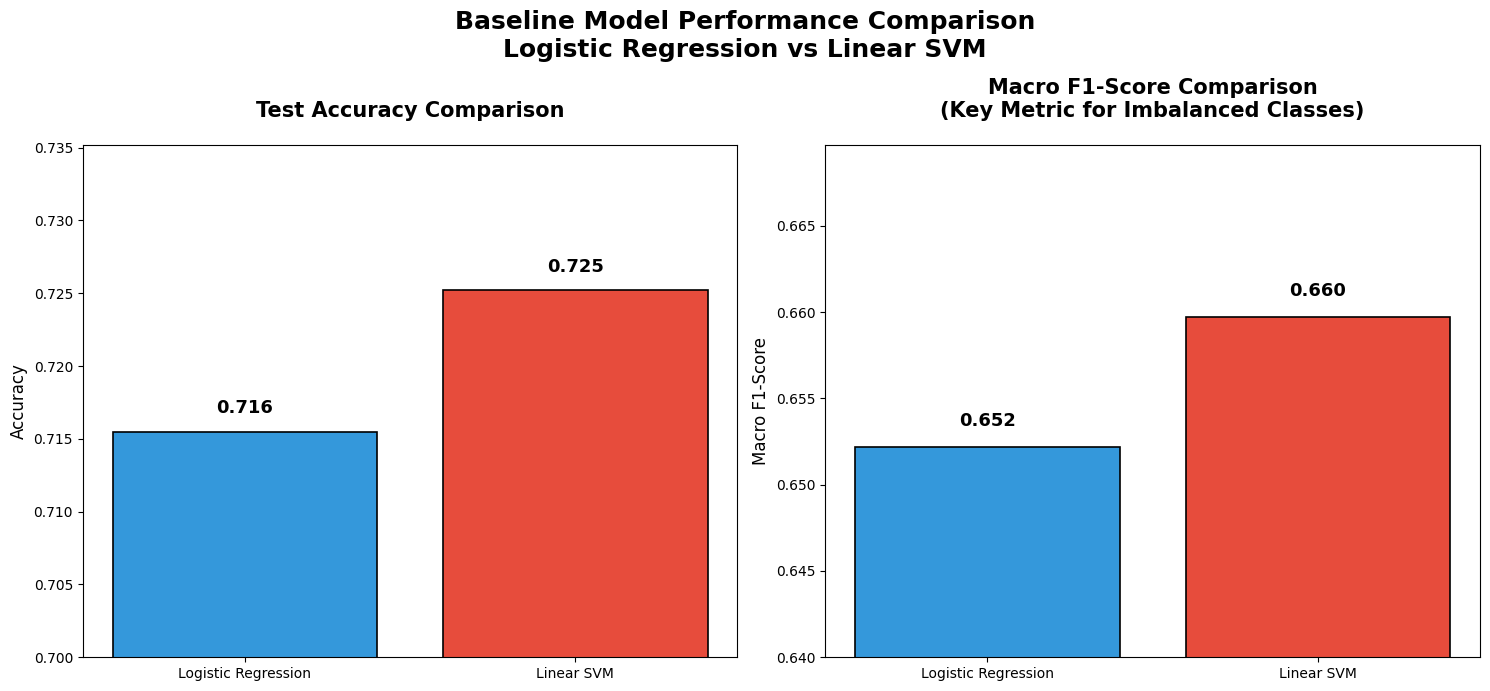


 Chart saved: /content/baseline_model_comparison_dynamic.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame
comparison_data = {
    'Model': ['Logistic Regression', 'Linear SVM'],
    'Accuracy': [lr_accuracy, svm_accuracy],
    'Macro F1': [lr_macro_f1, svm_macro_f1],
    'Weighted F1': [lr_weighted_f1, svm_weighted_f1]
}

df_compare = pd.DataFrame(comparison_data)
df_compare = df_compare.round(4)

# Print clean table
print("FINAL COMPARISON TABLE")
print("="*60)
print(df_compare.to_string(index=False))

# Beautiful Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

colors = ['#3498db', '#e74c3c']  # Blue for LR, Red for SVM

# Accuracy Bar
bars1 = ax1.bar(df_compare['Model'], df_compare['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_title('Test Accuracy Comparison', fontsize=15, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0.70, df_compare['Accuracy'].max() + 0.01)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=13)

# Macro F1 Bar
bars2 = ax2.bar(df_compare['Model'], df_compare['Macro F1'], color=colors, edgecolor='black', linewidth=1.2)
ax2.set_title('Macro F1-Score Comparison\n(Key Metric for Imbalanced Classes)', fontsize=15, fontweight='bold', pad=20)
ax2.set_ylabel('Macro F1-Score', fontsize=12)
ax2.set_ylim(0.64, df_compare['Macro F1'].max() + 0.01)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=13)

# Overall title
plt.suptitle('Baseline Model Performance Comparison\nLogistic Regression vs Linear SVM',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()

# Save high-quality image
chart_path = '/content/baseline_model_comparison_dynamic.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Chart saved: {chart_path}")

# Download the chart automatically
from google.colab import files
files.download(chart_path)

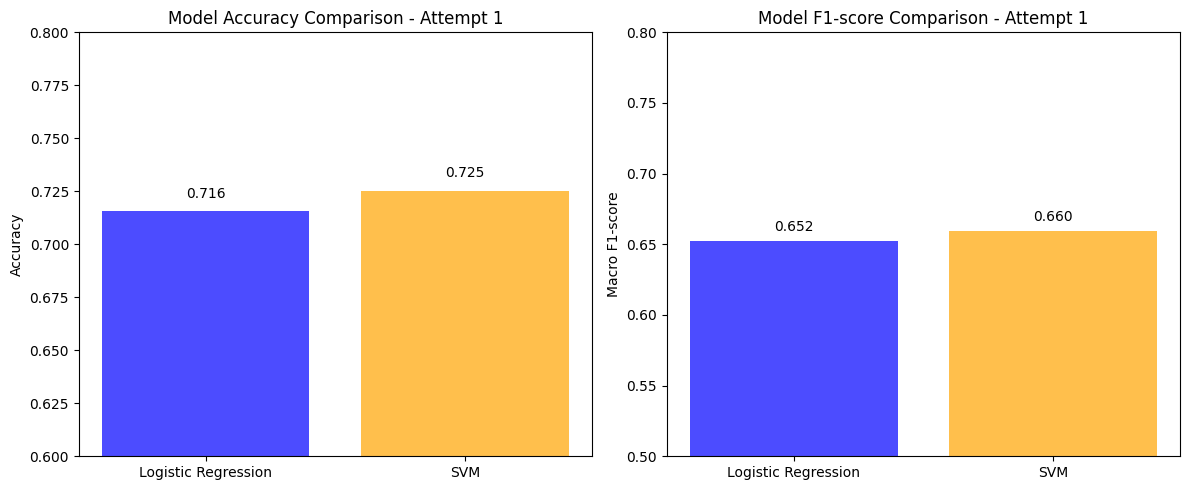

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use computed values
models = ['Logistic Regression', 'SVM']
accuracy_scores = [lr_accuracy, svm_accuracy]
macro_f1_scores = [lr_macro_f1, svm_macro_f1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
bars1 = ax1.bar(models, accuracy_scores, color=['blue', 'orange'], alpha=0.7)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison - Attempt 1')
ax1.set_ylim([0.6, 0.8])

# Add value labels on bars
for bar, val in zip(bars1, accuracy_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.3f}', ha='center', va='bottom')

# F1-score comparison
bars2 = ax2.bar(models, macro_f1_scores, color=['blue', 'orange'], alpha=0.7)
ax2.set_ylabel('Macro F1-score')
ax2.set_title('Model F1-score Comparison - Attempt 1')
ax2.set_ylim([0.5, 0.8])

# Add value labels on bars
for bar, val in zip(bars2, macro_f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('model_comparison_attempt1.png', dpi=300)
plt.show()

In [ ]:
#=====ATTEMPT 2: ENHANCED FEATURE ENGINEERING====
tfidf_enhanced = TfidfVectorizer(
    max_features=8000,           # Increased from 5000 to capture more features
    ngram_range=(1, 2),          # Include both unigrams and bigrams
    min_df=3,                    # Ignore terms appearing less than 3 times
    max_df=0.85,                 # Ignore terms appearing in more than 85% of docs
    stop_words='english',
    sublinear_tf=True           # Apply sublinear TF scaling
)
# Transform the data
print("   Transforming text data with enhanced TF-IDF")
X_train_enhanced = tfidf_enhanced.fit_transform(X_train)
X_test_enhanced = tfidf_enhanced.transform(X_test)

print(f"   Original features: 5000")
print(f"   Enhanced features: {X_train_enhanced.shape[1]} (including bigrams)")

   Transforming text data with enhanced TF-IDF
   Original features: 5000
   Enhanced features: 8000 (including bigrams)



Training Enhanced Models

Training Enhanced Logistic Regression
Enhanced LR  Accuracy: 0.7400 | Macro F1: 0.6864 | Weighted F1: 0.7371

Training Enhanced SVM with RBF kernel
Enhanced SVM  Accuracy: 0.7382 | Macro F1: 0.6786 | Weighted F1: 0.7379

FINAL 4-MODEL COMPARISON
                       Model  Accuracy  Macro F1  Weighted F1
Baseline Logistic Regression    0.7155    0.6522       0.7198
         Baseline Linear SVM    0.7252    0.6597       0.7255
Enhanced Logistic Regression    0.7400    0.6864       0.7371
          Enhanced SVM (RBF)    0.7382    0.6786       0.7379


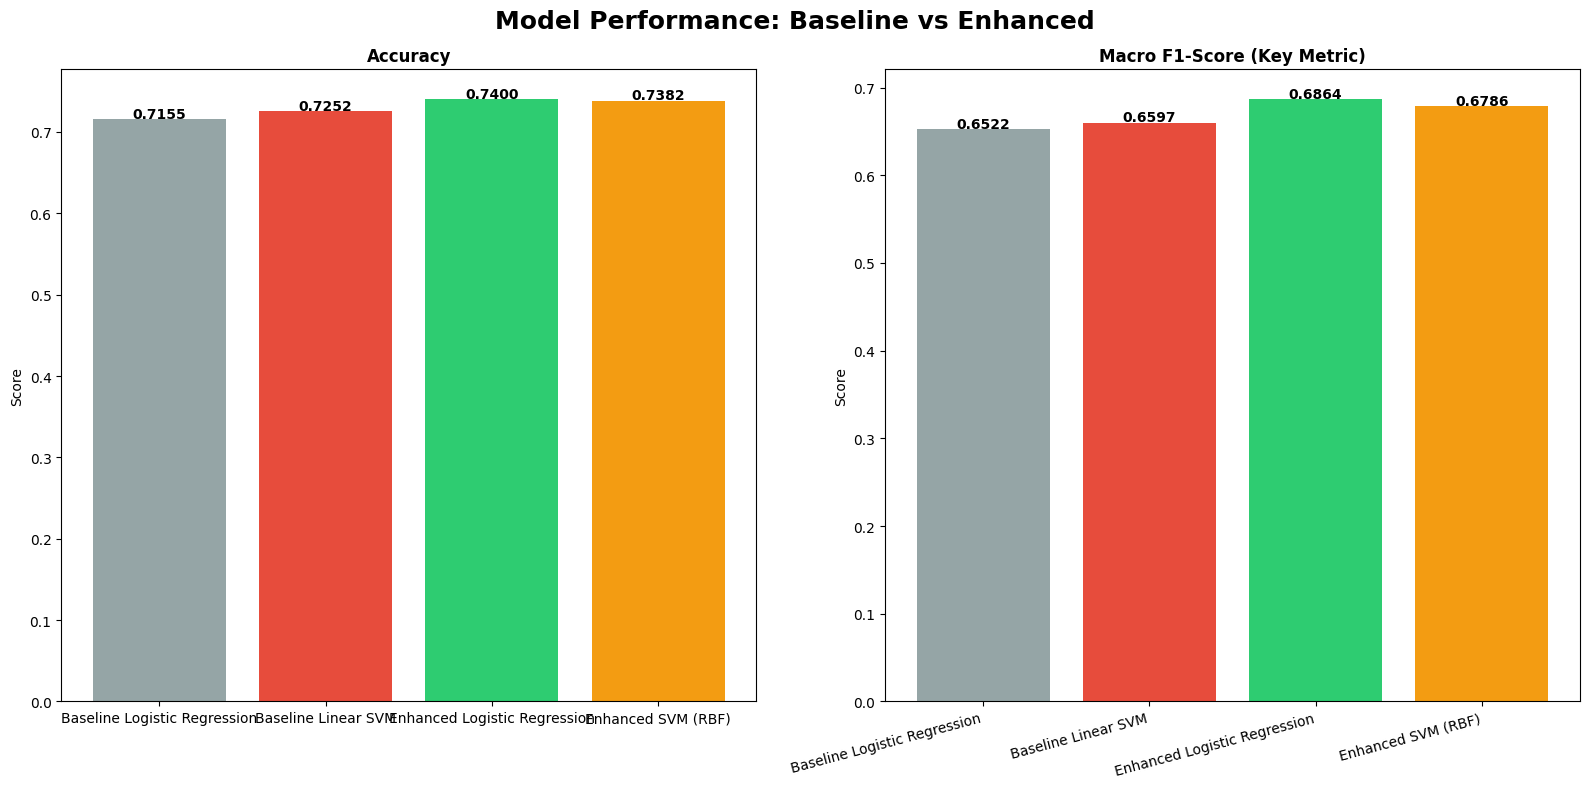

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from google.colab import files

print("\nTraining Enhanced Models\n")

# === Enhanced Logistic Regression ===
print("Training Enhanced Logistic Regression")
lr_enhanced = LogisticRegression(
    C=1.0,
    solver='liblinear',
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)
lr_enhanced.fit(X_train_enhanced, y_train)
y_pred_lr_enhanced = lr_enhanced.predict(X_test_enhanced)

# Metrics
lr_enh_acc = accuracy_score(y_test, y_pred_lr_enhanced)
lr_enh_macro = f1_score(y_test, y_pred_lr_enhanced, average='macro')
lr_enh_weighted = f1_score(y_test, y_pred_lr_enhanced, average='weighted')

print(f"Enhanced LR  Accuracy: {lr_enh_acc:.4f} | Macro F1: {lr_enh_macro:.4f} | Weighted F1: {lr_enh_weighted:.4f}")

# === Enhanced SVM (RBF) ===
print("\nTraining Enhanced SVM with RBF kernel")
svm_enhanced = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
svm_enhanced.fit(X_train_enhanced, y_train)
y_pred_svm_enhanced = svm_enhanced.predict(X_test_enhanced)

# Metrics
svm_enh_acc = accuracy_score(y_test, y_pred_svm_enhanced)
svm_enh_macro = f1_score(y_test, y_pred_svm_enhanced, average='macro')
svm_enh_weighted = f1_score(y_test, y_pred_svm_enhanced, average='weighted')

print(f"Enhanced SVM  Accuracy: {svm_enh_acc:.4f} | Macro F1: {svm_enh_macro:.4f} | Weighted F1: {svm_enh_weighted:.4f}")

# === FULL 4-MODEL COMPARISON (using your known baseline values) ===
comparison_data = {
    'Model': [
        'Baseline Logistic Regression',
        'Baseline Linear SVM',
        'Enhanced Logistic Regression',
        'Enhanced SVM (RBF)'
    ],
    'Accuracy': [0.7155, 0.7252, lr_enh_acc, svm_enh_acc],
    'Macro F1': [0.6522, 0.6597, lr_enh_macro, svm_enh_macro],
    'Weighted F1': [0.7198, 0.7255, lr_enh_weighted, svm_enh_weighted]
}

df_compare = pd.DataFrame(comparison_data).round(4)

print("\n" + "="*80)
print("FINAL 4-MODEL COMPARISON")
print("="*80)
print(df_compare.to_string(index=False))

# === Bar Chart ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
colors = ['#95a5a6', '#e74c3c', '#2ecc71', '#f39c12']

ax1.bar(df_compare['Model'], df_compare['Accuracy'], color=colors)
ax1.set_title('Accuracy', fontweight='bold')
ax1.set_ylabel('Score')
for i, v in enumerate(df_compare['Accuracy']):
    ax1.text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

ax2.bar(df_compare['Model'], df_compare['Macro F1'], color=colors)
ax2.set_title('Macro F1-Score (Key Metric)', fontweight='bold')
ax2.set_ylabel('Score')
for i, v in enumerate(df_compare['Macro F1']):
    ax2.text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('Model Performance: Baseline vs Enhanced', fontsize=18, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('/content/enhanced_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/enhanced_comparison_final.png')

In [ ]:
save_dir = Path('/content/saved_models')
save_dir.mkdir(exist_ok=True)

print("\nSAVING ENHANCED MODELS...\n")
joblib.dump(tfidf_enhanced, save_dir / 'tfidf_enhanced.pkl')
joblib.dump(lr_enhanced, save_dir / 'lr_enhanced.pkl')
joblib.dump(svm_enhanced, save_dir / 'svm_rbf_enhanced.pkl')

print("Enhanced models saved!")

!zip -r /content/ENHANCED_MODELS_MILESTONE2.zip /content/saved_models/
files.download('/content/ENHANCED_MODELS_MILESTONE2.zip')


SAVING ENHANCED MODELS...

Enhanced models saved!
  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/svm_rbf_enhanced.pkl (deflated 31%)
  adding: content/saved_models/tfidf_enhanced.pkl (deflated 71%)
  adding: content/saved_models/lr_enhanced.pkl (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
from pathlib import Path

save_dir = Path('/content/saved_models')

print("Loading saved models for visualization...\n")

# Baseline
tfidf_baseline = joblib.load('tfidf_vectorizer.pkl')  # adjust name if different
lr_baseline = joblib.load('/content/best_logistic_regression.pkl')
svm_baseline = joblib.load('/content/linear_svm.pkl')

# Enhanced
tfidf_enhanced = joblib.load(save_dir / 'tfidf_enhanced.pkl')
lr_enhanced = joblib.load(save_dir / 'lr_enhanced.pkl')
svm_enhanced = joblib.load(save_dir / 'svm_rbf_enhanced.pkl')

print("All 6 artifacts loaded successfully!")

Loading saved models for visualization...



FileNotFoundError: [Errno 2] No such file or directory: 'tfidf_vectorizer.pkl'

In [ ]:
from sklearn.model_selection import train_test_split

# Recreate exact same split
X = df['clean_text']
y = df['status']
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Transform with both vectorizers
X_test_baseline = tfidf_baseline.transform(X_test)
X_test_enhanced = tfidf_enhanced.transform(X_test)

print("Test features ready for predictions!")

Test features ready for predictions!


In [ ]:
# Predictions
y_pred_lr_base = lr_baseline.predict(X_test_baseline)
y_pred_svm_base = svm_baseline.predict(X_test_baseline)
y_pred_lr_enh = lr_enhanced.predict(X_test_enhanced)
y_pred_svm_enh = svm_enhanced.predict(X_test_enhanced)

print("All predictions completed!")

ValueError: X has 5000 features, but LinearSVC is expecting 8000 features as input.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Enhanced metrics
lr_enh_acc = accuracy_score(y_test, y_pred_lr_enh)
lr_enh_macro = f1_score(y_test, y_pred_lr_enh, average='macro')

svm_enh_acc = accuracy_score(y_test, y_pred_svm_enhanced)
svm_enh_macro = f1_score(y_test, y_pred_svm_enhanced, average='macro')

print("Enhanced Model Metrics:")
print(f"Enhanced Logistic Regression Accuracy: {lr_enh_acc:.4f}, Macro F1: {lr_enh_macro:.4f}")
print(f"Enhanced SVM  Accuracy: {svm_enh_acc:.4f}, Macro F1: {svm_enh_macro:.4f}")

In [ ]:
import pandas as pd

comparison_data = {
    'Model': [
        'Baseline Logistic Regression',
        'Baseline Linear SVM',
        'Enhanced Logistic Regression',
        'Enhanced SVM (RBF)'
    ],
    'Accuracy': [0.7155, 0.7252, lr_enh_acc, svm_enh_acc],
    'Macro F1': [0.6522, 0.6597, lr_enh_macro, svm_enh_macro]
}

df_compare = pd.DataFrame(comparison_data).round(4)

print("FINAL MODEL COMPARISON TABLE")
print("="*50)
print(df_compare.to_string(index=False))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(df_compare['Model'], df_compare['Accuracy'], color=['#95a5a6', '#e74c3c', '#2ecc71', '#f39c12'])
plt.title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0.70, df_compare['Accuracy'].max() + 0.01)
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002, f'{height:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('/content/accuracy_comparison.png')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(df_compare['Model'], df_compare['Macro F1'], color=['#95a5a6', '#e74c3c', '#2ecc71', '#f39c12'])
plt.title('Macro F1-Score Comparison', fontweight='bold', fontsize=14)
plt.ylabel('Macro F1-Score')
plt.ylim(0.64, df_compare['Macro F1'].max() + 0.01)
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002, f'{height:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/macro_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/macro_f1_comparison.png')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for Enhanced Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr_enhanced)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix of Enhanced Logistic Regression', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/confusion_matrix_enhanced_lr.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('/content/confusion_matrix_enhanced_lr.png')

print("Confusion Matrix saved and downloaded: confusion_matrix_enhanced_lr.png")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm_enh)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix of Enhanced SVM ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/confusion_matrix_enhanced_svm.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/confusion_matrix_enhanced_svm.png')

In [ ]:
print("SAMPLE PREDICTIONS - Enhanced SVM (Best Model)\n")
sample_idx = X_test.index[:5]
for i, idx in enumerate(sample_idx):
    text = df.loc[idx, 'statement']
    true = y_test.loc[idx]
    pred = y_pred_svm_enh[i]
    print(f"Example {i+1}:")
    print(f"Text: {text[:150]}")
    print(f"True: {true} | Predicted: {pred}\n")

In [ ]:
print("SAMPLE PREDICTIONS on Enhanced Logistic Regression\n")

sample_idx = X_test.index[:6]  # 6 examples for better comparison

print("Example | True Label       | Predicted (LR)   | Text Preview")
print("-" * 80)

for i, idx in enumerate(sample_idx):
    text = df.loc[idx, 'statement']
    true = y_test.loc[idx]
    pred_lr = y_pred_lr_enhanced[i]

    correct = "✔" if true == pred_lr else "X"

    print(f"{i+1:7} | {true:16} | {pred_lr:14} {correct} | {text[:100]}...")
    print()

SAMPLE PREDICTIONS on Enhanced Logistic Regression

Example | True Label       | Predicted (LR)   | Text Preview
--------------------------------------------------------------------------------
      1 | Stress           | Depression     X | I recently went through an event that was extremely traumatic. Without specifying what, it was recen...

      2 | Normal           | Normal         ✔ | I want to rest but what if I win the giveaway...

      3 | Suicidal         | Suicidal       ✔ | Basically bro when you die you gon feel all the pain you put people thru, So if you kill yourself yo...

      4 | Depression       | Depression     ✔ | Today marks 1 month since we broke up and there has not been one single day I did not wake up thinki...

      5 | Normal           | Normal         ✔ | Writing these helps sooth my own wounds, and I was wondering if people would be willing to read them...

      6 | Normal           | Stress         X | A <url> has been set up and I’m hoping to help g

In [ ]:
print("SAMPLE PREDICTIONS on Enhanced SVM (RBF Kernel)\n")

print("Example | True Label       | Predicted (SVM)  | Text Preview")
print("-" * 80)

for i, idx in enumerate(sample_idx):  # Same indexes as above!
    text = df.loc[idx, 'statement']
    true = y_test.loc[idx]
    pred_svm = y_pred_svm_enhanced[i]

    correct = "✔" if true == pred_svm else "X"

    print(f"{i+1:7} | {true:16} | {pred_svm:14} {correct} | {text[:100]}...")
    print()

SAMPLE PREDICTIONS on Enhanced SVM (RBF Kernel)

Example | True Label       | Predicted (SVM)  | Text Preview
--------------------------------------------------------------------------------
      1 | Stress           | Depression     X | I recently went through an event that was extremely traumatic. Without specifying what, it was recen...

      2 | Normal           | Normal         ✔ | I want to rest but what if I win the giveaway...

      3 | Suicidal         | Suicidal       ✔ | Basically bro when you die you gon feel all the pain you put people thru, So if you kill yourself yo...

      4 | Depression       | Depression     ✔ | Today marks 1 month since we broke up and there has not been one single day I did not wake up thinki...

      5 | Normal           | Normal         ✔ | Writing these helps sooth my own wounds, and I was wondering if people would be willing to read them...

      6 | Normal           | Normal         ✔ | A <url> has been set up and I’m hoping to help get 

In [ ]:
print("DIRECT COMPARISON OF ENHANCED MODELS ON SAME SAMPLES")

matches = 0
for i in range(len(sample_idx)):
    if y_pred_lr_enhanced[i] == y_pred_svm_enhanced[i]:
        matches += 1

print(f"Both models agree on {matches} out of {len(sample_idx)} samples")


DIRECT COMPARISON OF ENHANCED MODELS ON SAME SAMPLES
Both models agree on 5 out of 6 samples


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
proba_lr = lr_enhanced.predict_proba(X_test_enhanced)

auc_lr_macro = roc_auc_score(y_test_bin, proba_lr, average='macro', multi_class='ovr')

print("MACRO ROC AUC SCORE")
print(f"Enhanced Logistic Regression: {auc_lr_macro:.4f}")
print("(Higher is better — 1.0 = perfect, 0.5 = random)")

MACRO ROC AUC SCORE
Enhanced Logistic Regression: 0.9306
(Higher is better — 1.0 = perfect, 0.5 = random)


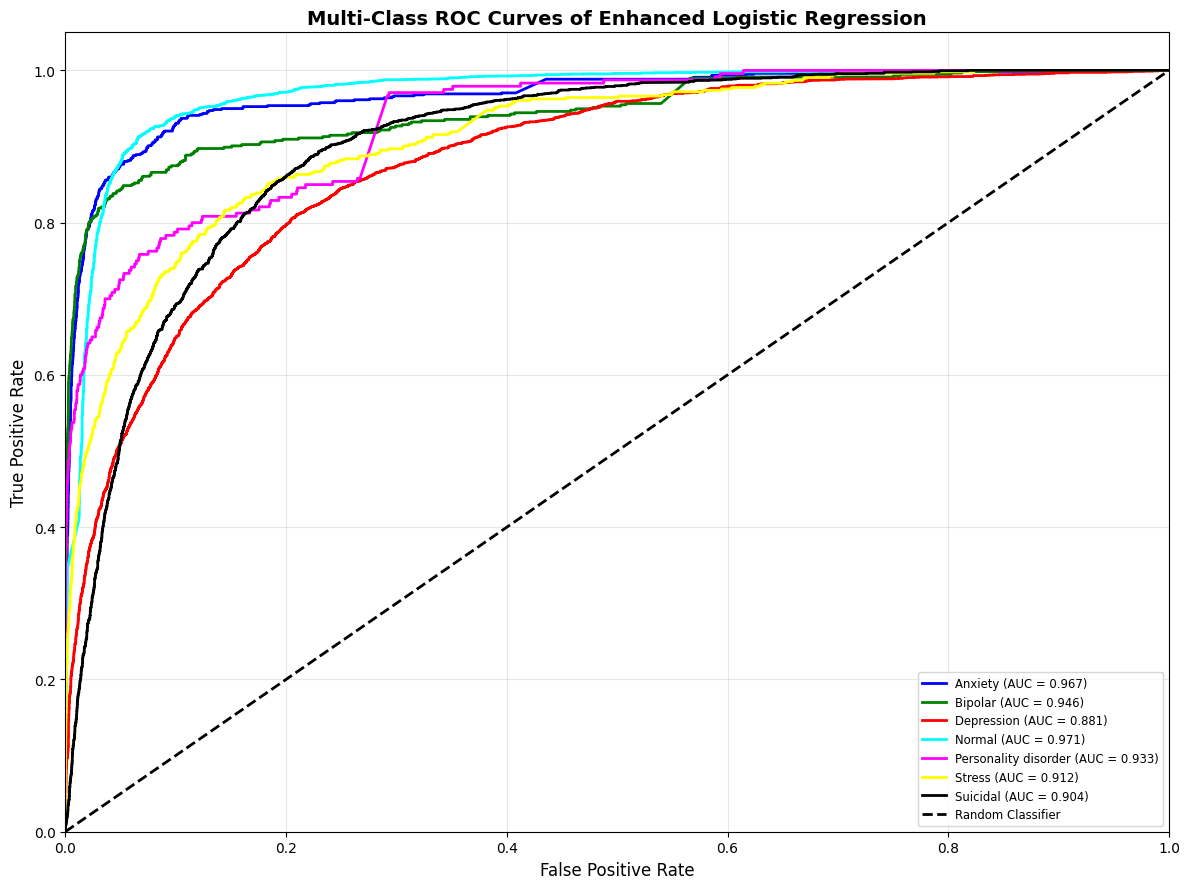

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 9))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'{cls} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curves of Enhanced Logistic Regression', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/roc_curves_enhanced_lr.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('/content/roc_curves_enhanced_lr.png')

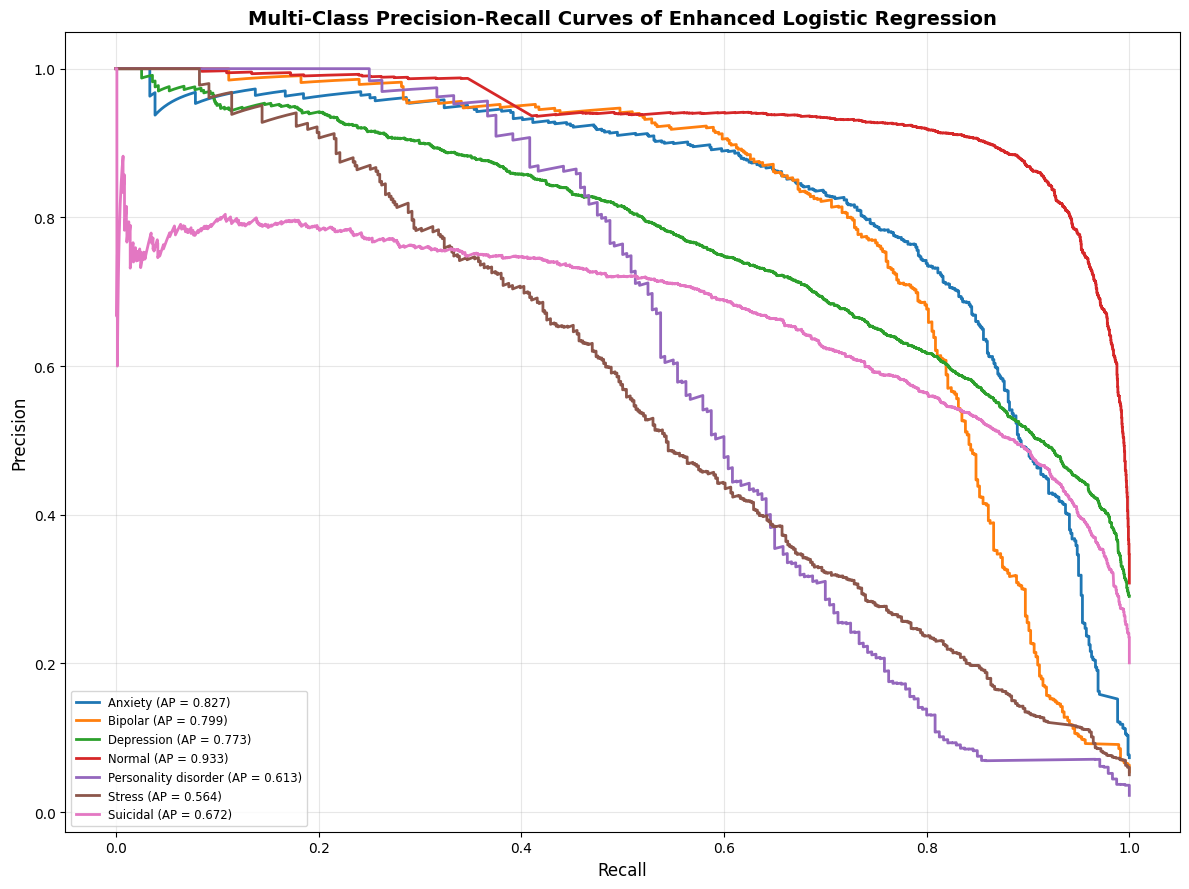

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 9))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], proba_lr[:, i])
    ap = average_precision_score(y_test_bin[:, i], proba_lr[:, i])
    plt.plot(recall, precision, lw=2, label=f'{cls} (AP = {ap:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Multi-Class Precision-Recall Curves of Enhanced Logistic Regression', fontweight='bold', fontsize=14)
plt.legend(loc="best", fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pr_curves_enhanced_lr.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/pr_curves_enhanced_lr.png')

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Decision scores from SVM
decision_svm = svm_enhanced.decision_function(X_test_enhanced)

auc_svm_macro = roc_auc_score(y_test_bin, decision_svm, average='macro', multi_class='ovr')

print("MACRO ROC AUC SCORE (using decision function)")
print(f"Enhanced SVM (RBF): {auc_svm_macro:.4f}")
print("Note: SVM uses distance to hyperplane as score  still valid for ranking")

MACRO ROC AUC SCORE (using decision function)
Enhanced SVM (RBF): 0.9192
Note: SVM uses distance to hyperplane as score  still valid for ranking


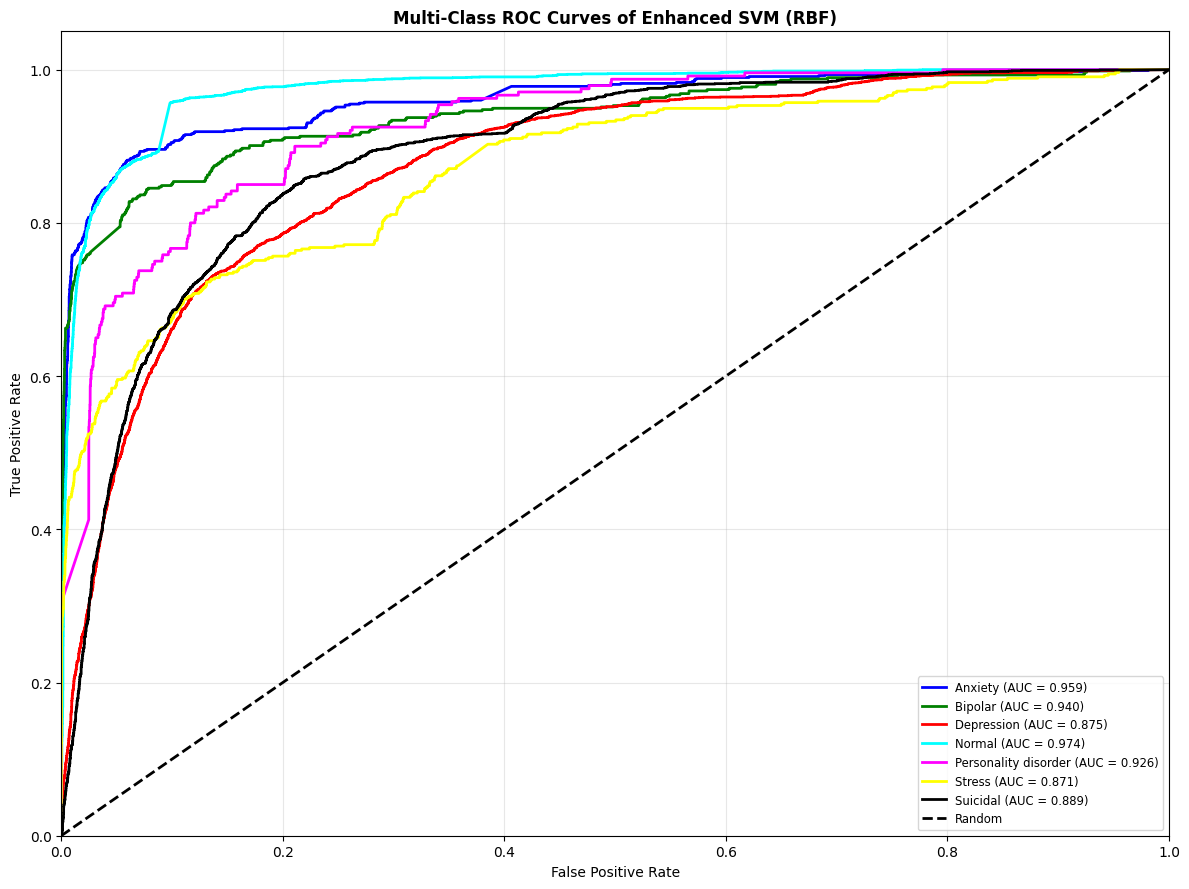

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], decision_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 9))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'{cls} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves of Enhanced SVM (RBF)', fontweight='bold')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/roc_curves_enhanced_svm.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('/content/roc_curves_enhanced_svm.png')

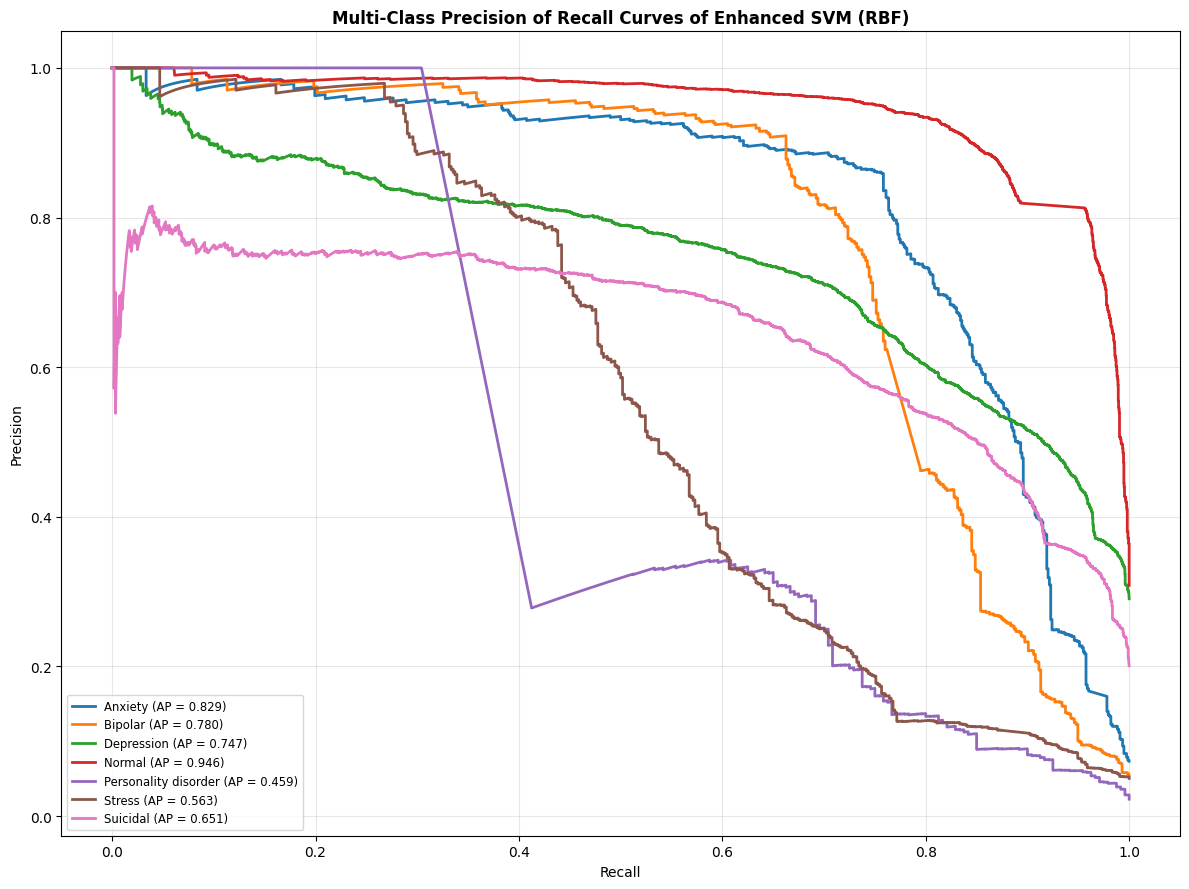

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 9))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], decision_svm[:, i])
    ap = average_precision_score(y_test_bin[:, i], decision_svm[:, i])
    plt.plot(recall, precision, lw=2, label=f'{cls} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision of Recall Curves of Enhanced SVM (RBF)', fontweight='bold')
plt.legend(loc="best", fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pr_curves_enhanced_svm.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/pr_curves_enhanced_svm.png')

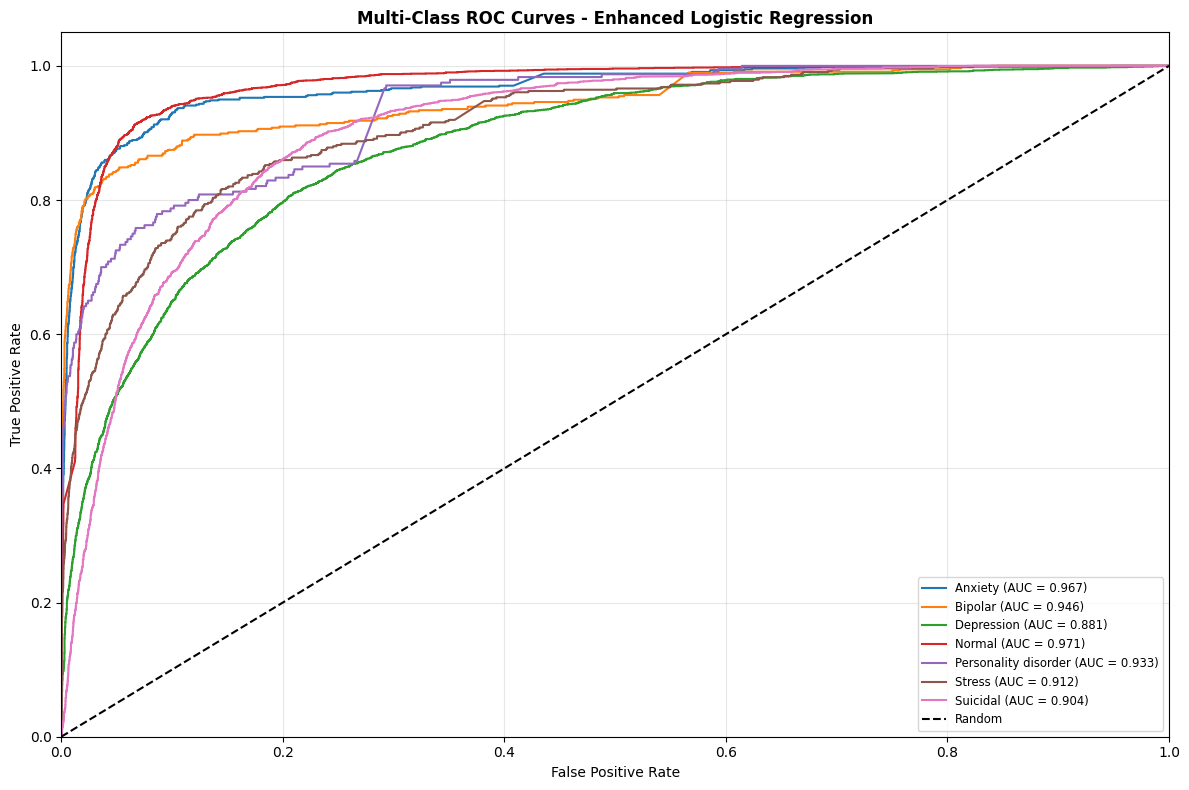

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'{cls} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves - Enhanced Logistic Regression', fontweight='bold')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/roc_curves_enhanced_lr.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('/content/roc_curves_enhanced_lr.png')

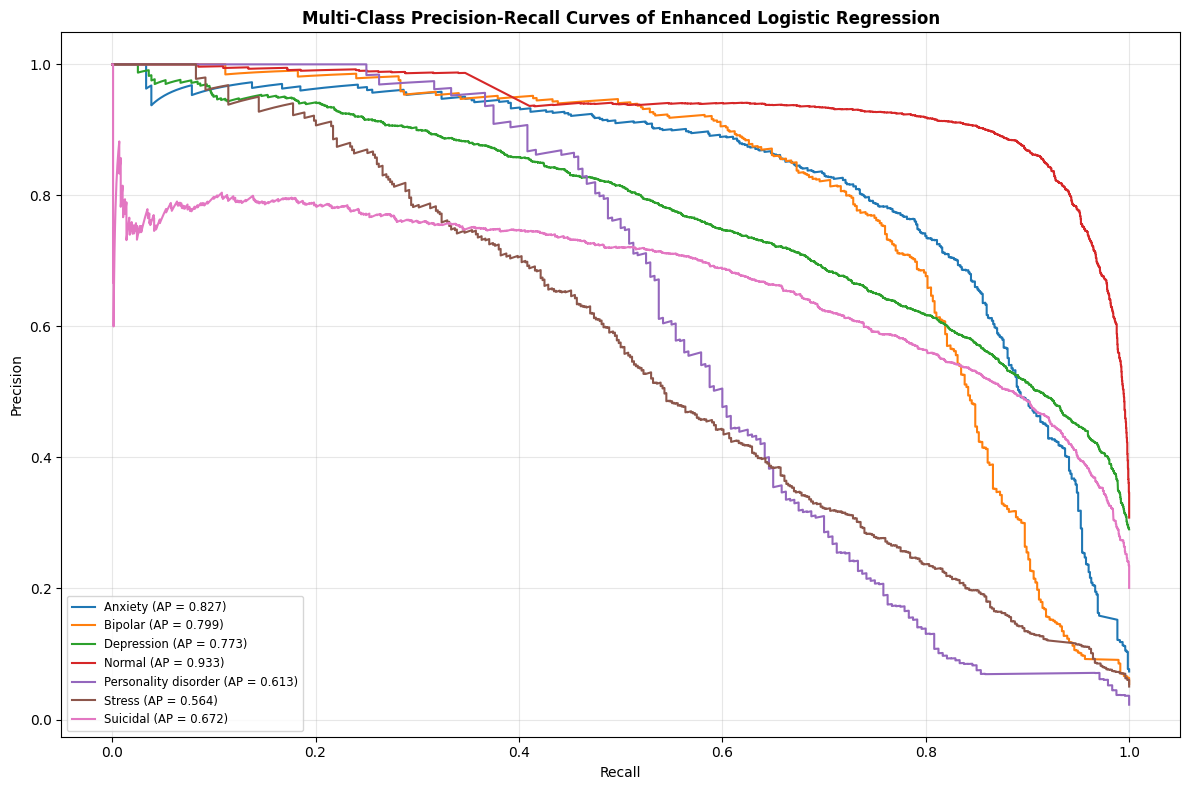

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], proba_lr[:, i])
    ap = average_precision_score(y_test_bin[:, i], proba_lr[:, i])
    plt.plot(recall, precision, label=f'{cls} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curves of Enhanced Logistic Regression', fontweight='bold')
plt.legend(loc='lower left', fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pr_curves_enhanced_lr.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/pr_curves_enhanced_lr.png')

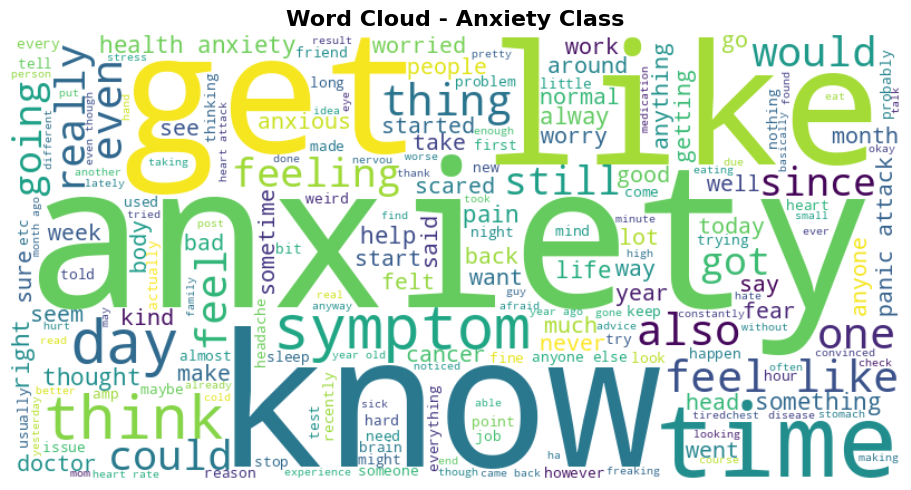

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

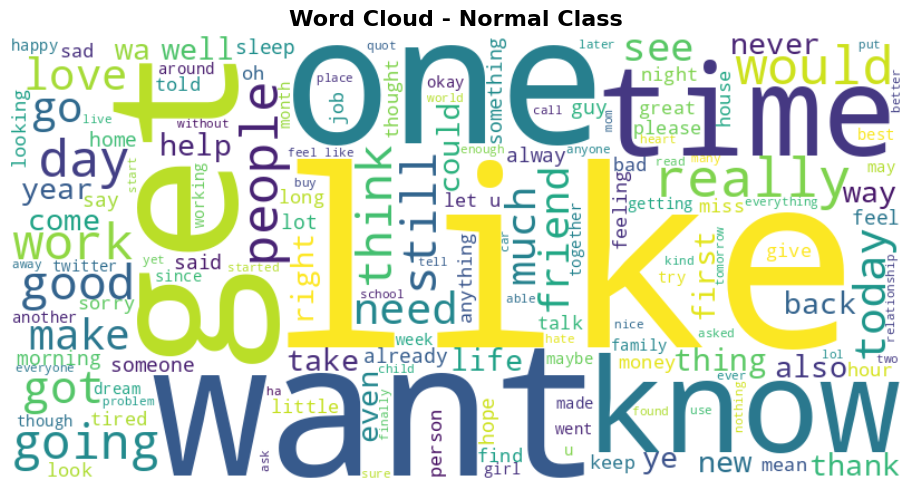

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

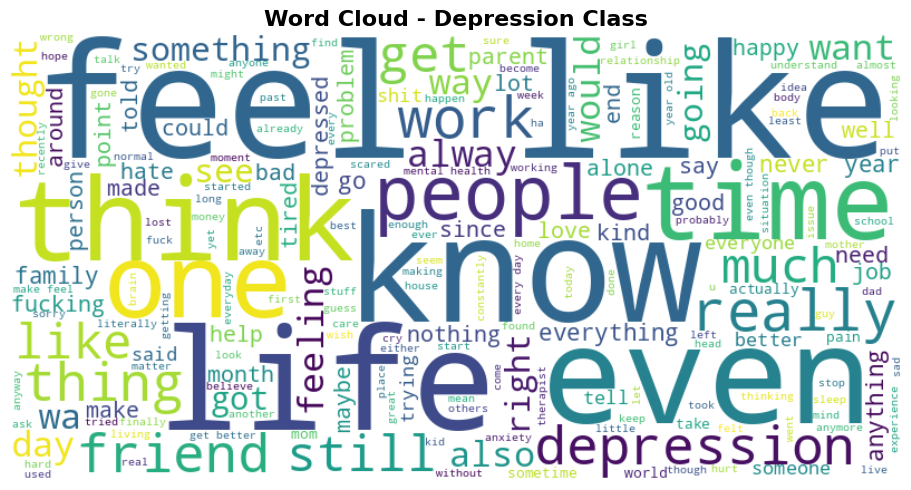

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

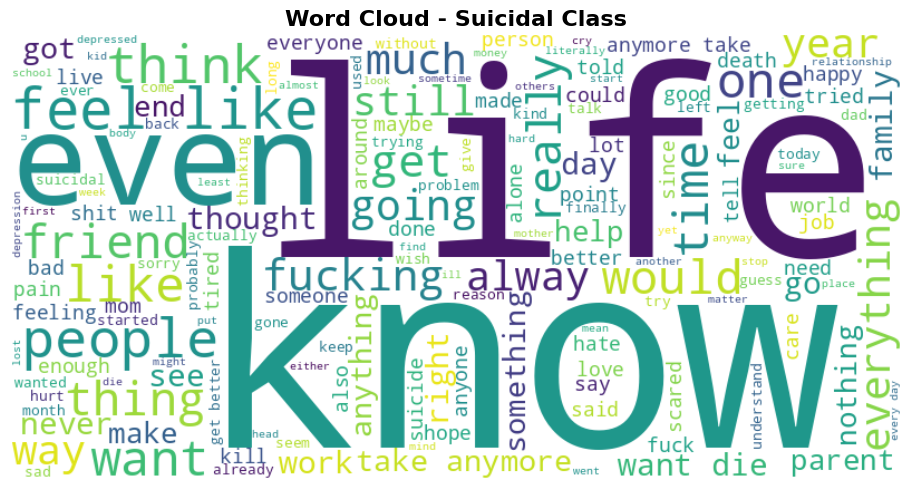

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

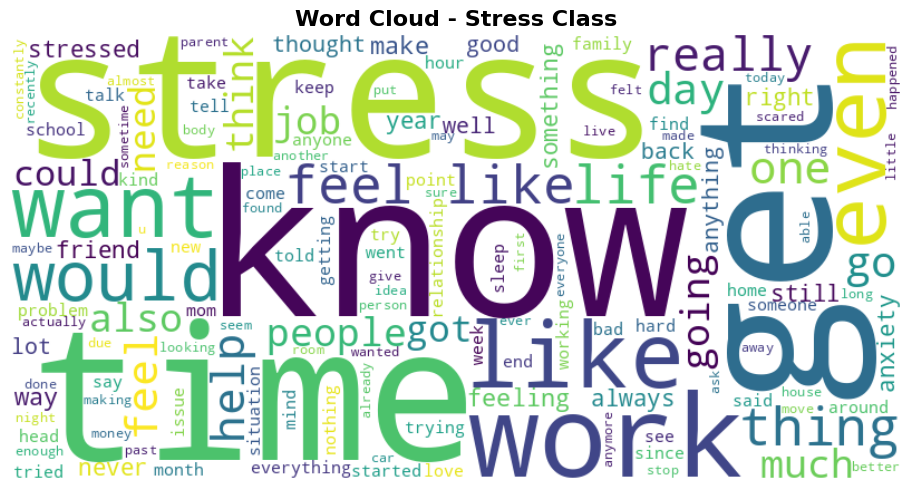

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

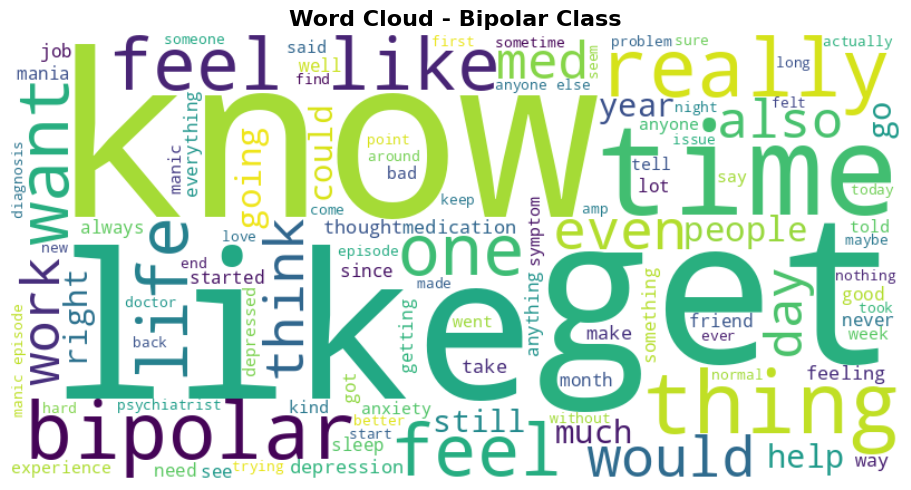

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

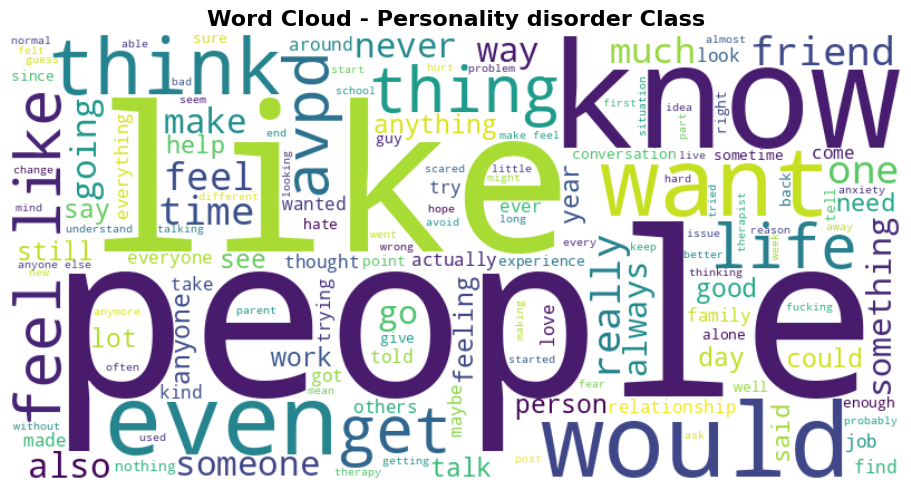

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

classes = df['status'].unique()

for cls in classes:
    text = ' '.join(df[df['status'] == cls]['clean_text'].dropna())

    if text.strip() == '':
        print(f"No text for class: {cls}")
        continue

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords='english', min_font_size=10).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {cls} Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/wordcloud_{cls.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

    from google.colab import files
    files.download(f'/content/wordcloud_{cls.replace(" ", "_")}.png')

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], proba_svm[:, i])
    ap = average_precision_score(y_test_bin[:, i], proba_lr[:, i])
    plt.plot(recall, precision, label=f'{cls} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curves of  Enhanced SVM', fontweight='bold')
plt.legend(loc='lower left', fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/pr_curves_enhanced_svm.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/pr_curves_enhanced_svm.png')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\n. Computing Enhanced Results")

# Compute metrics for enhanced models
lr_enhanced_accuracy = accuracy_score(y_test, y_pred_lr_enhanced)
lr_enhanced_macro_f1 = f1_score(y_test, y_pred_lr_enhanced, average='macro')
lr_enhanced_weighted_f1 = f1_score(y_test, y_pred_lr_enhanced, average='weighted')

svm_enhanced_accuracy = accuracy_score(y_test, y_pred_svm_enhanced)
svm_enhanced_macro_f1 = f1_score(y_test, y_pred_svm_enhanced, average='macro')
svm_enhanced_weighted_f1 = f1_score(y_test, y_pred_svm_enhanced, average='weighted')

In [ ]:
print("ENHANCED RESULTS vs BASELINE")
print("="*60)
# Create comparison table
comparison_data = {
    'Model': ['Logistic Regression', 'Logistic Regression',
              'SVM (Linear)', 'SVM (RBF)'],
    'Version': ['Baseline', 'Enhanced', 'Baseline', 'Enhanced'],
    'Accuracy': [lr_accuracy, lr_enhanced_accuracy,
                 svm_accuracy, svm_enhanced_accuracy],
    'Macro F1': [lr_macro_f1, lr_enhanced_macro_f1,
                 svm_macro_f1, svm_enhanced_macro_f1],
    'Weighted F1': [lr_weighted_f1, lr_enhanced_weighted_f1,
                    svm_weighted_f1, svm_enhanced_weighted_f1]
}

df_enhanced_comparison = pd.DataFrame(comparison_data)
print("\nPerformance Comparison:")
print(df_enhanced_comparison.to_string(index=False))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search.fit(X_train_ngram, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
# Train with best parameters
lr_optimized = LogisticRegression(
    C=10,
    solver='saga',
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)
lr_optimized.fit(X_train_ngram, y_train)
y_pred_lr_opt = lr_optimized.predict(X_test_ngram)

print("Optimized Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_opt):.3f}")
print(f"Macro F1: {f1_score(y_test, y_pred_lr_opt, average='macro'):.3f}")
print(classification_report(y_test, y_pred_lr_opt))

In [ ]:
# SVM with RBF kernel
svm_rbf = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
svm_rbf.fit(X_train_ngram, y_train)
y_pred_svm_opt = svm_rbf.predict(X_test_ngram)

print("Optimized SVM (RBF Kernel) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_opt):.3f}")
print(f"Macro F1: {f1_score(y_test, y_pred_svm_opt, average='macro'):.3f}")

In [ ]:
# Install
!pip install transformers datasets torch accelerate -q

In [ ]:
# Install latest transformers
!pip install transformers datasets torch accelerate -q --upgrade

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split

classes = sorted(df['status'].unique())
label2id = {label: i for i, label in enumerate(classes)}
id2label = {i: label for label, i in label2id.items()}

df['label'] = df['status'].map(label2id)

# Split (same as before)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['status'])

train_ds = Dataset.from_pandas(train_df[['clean_text', 'label']])
test_ds = Dataset.from_pandas(test_df[['clean_text', 'label']])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['clean_text'], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.remove_columns(['clean_text'])
tokenized_test = tokenized_test.remove_columns(['clean_text'])
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=7,
    label2id=label2id,
    id2label=id2label
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "macro_f1": macro_f1}

# Fixed TrainingArguments
training_args = TrainingArguments(
    output_dir='./bert_mh_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
    fp16=True if torch.cuda.is_available() else False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# Train!
print("Starting BERT fine-tuning...")
trainer.train()

# Evaluate
results = trainer.evaluate()
print("\nBERT Fine-Tuning Results:")
print(results)

# Save
model.save_pretrained('./bert_mental_health_finetuned')
tokenizer.save_pretrained('./bert_mental_health_finetuned')
print("BERT model saved!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90

Map:   0%|          | 0/42434 [00:00<?, ? examples/s]

Map:   0%|          | 0/10609 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT fine-tuning...



BERT Fine-Tuning Results:
{'eval_loss': 0.6434460878372192, 'eval_accuracy': 0.7840512772174568, 'eval_macro_f1': 0.7482497057993402, 'eval_runtime': 19.6312, 'eval_samples_per_second': 540.416, 'eval_steps_per_second': 33.824, 'epoch': 3.0}
BERT model saved!


In [ ]:
# Save the fine-tuned model and tokenizer
model_save_path = '/content/bert_mental_health_finetuned'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"BERT model and tokenizer saved to: {model_save_path}")
print("Files created:")
!ls -lh {model_save_path}

BERT model and tokenizer saved to: /content/bert_mental_health_finetuned
Files created:
total 418M
-rw-r--r-- 1 root root 1017 Dec 31 04:14 config.json
-rw-r--r-- 1 root root 418M Dec 31 04:14 model.safetensors
-rw-r--r-- 1 root root  125 Dec 31 04:14 special_tokens_map.json
-rw-r--r-- 1 root root 1.3K Dec 31 04:14 tokenizer_config.json
-rw-r--r-- 1 root root 227K Dec 31 04:14 vocab.txt


In [ ]:
# # ZIP the folder for easy download
# !zip -r /content/bert_mental_health_finetuned.zip /content/bert_mental_health_finetuned/

# # Download
# from google.colab import files
# files.download('/content/bert_mental_health_finetuned.zip')

# print("Download started — save this ZIP file to your computer!")


  adding: content/bert_mental_health_finetuned/ (stored 0%)
  adding: content/bert_mental_health_finetuned/special_tokens_map.json (deflated 42%)
  adding: content/bert_mental_health_finetuned/tokenizer_config.json (deflated 75%)
  adding: content/bert_mental_health_finetuned/config.json (deflated 52%)
  adding: content/bert_mental_health_finetuned/vocab.txt (deflated 53%)
  adding: content/bert_mental_health_finetuned/model.safetensors (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started — save this ZIP file to your computer!


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

print("\nTraining Tuned Linear SVM (Text-Optimized)\n")

# Parameter grid (small but effective)
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5]
}

svm_linear = LinearSVC(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

grid_svm = GridSearchCV(
    estimator=svm_linear,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_enhanced, y_train)

best_svm = grid_svm.best_estimator_

print("Best SVM C value:", grid_svm.best_params_['C'])



Training Tuned Linear SVM (Text-Optimized)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best SVM C value: 0.1


In [ ]:
# Predictions
y_pred_svm_tuned = best_svm.predict(X_test_enhanced)

# Metrics
svm_tuned_acc = accuracy_score(y_test, y_pred_svm_tuned)
svm_tuned_macro = f1_score(y_test, y_pred_svm_tuned, average='macro')
svm_tuned_weighted = f1_score(y_test, y_pred_svm_tuned, average='weighted')

print(
    f"Tuned Linear SVM | "
    f"Accuracy: {svm_tuned_acc:.4f} | "
    f"Macro F1: {svm_tuned_macro:.4f} | "
    f"Weighted F1: {svm_tuned_weighted:.4f}"
)


Tuned Linear SVM | Accuracy: 0.7390 | Macro F1: 0.6828 | Weighted F1: 0.7356


In [ ]:
#save

In [ ]:
# import joblib
# from pathlib import Path

# save_dir = Path('/content/saved_models')
# save_dir.mkdir(exist_ok=True)

# # Save the tuned SVM
# joblib.dump(best_svm, save_dir / 'tuned_linear_svm_best.pkl')
# print("Tuned Linear SVM saved as 'tuned_linear_svm_best.pkl'")

# # Also save the GridSearch results if you want
# joblib.dump(grid_svm, save_dir / 'gridsearch_svm_results.pkl')
# print("GridSearch object saved")

# # List all saved models
# print("\nAll saved models in folder:")
# !ls -lh /content/saved_models/

Tuned Linear SVM saved as 'tuned_linear_svm_best.pkl'
GridSearch object saved

All saved models in folder:
total 884K
-rw-r--r-- 1 root root 442K Dec 31 04:38 gridsearch_svm_results.pkl
-rw-r--r-- 1 root root 439K Dec 31 04:38 tuned_linear_svm_best.pkl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = '/content/drive/MyDrive/AML/23048596 Jeshmin Shrestha'
os.listdir(folder_path)


['tfidf_vectorizer.pkl',
 'svm_rbf_enhanced.pkl',
 'tuned_linear_svm_best.pkl',
 'tfidf_enhanced.pkl',
 'special_tokens_map.json',
 'config.json',
 'vocab.txt',
 'lr_enhanced.pkl',
 'tokenizer_config.json',
 'gridsearch_svm_results.pkl',
 'model.safetensors',
 'sentiment-analysis-for-mental-health.csv']

In [ ]:
import os
import joblib

# Check all files in the folder
print(os.listdir(folder_path))

# Load models
lr_model = joblib.load(os.path.join(folder_path, 'lr_enhanced.pkl'))
linear_svm_model = joblib.load(os.path.join(folder_path, 'tuned_linear_svm_best.pkl'))
rbf_svm_model = joblib.load(os.path.join(folder_path, 'svm_rbf_enhanced.pkl'))
tfidf_vectorizer = joblib.load(os.path.join(folder_path, 'tfidf_enhanced.pkl'))


['tfidf_vectorizer.pkl', 'svm_rbf_enhanced.pkl', 'tuned_linear_svm_best.pkl', 'tfidf_enhanced.pkl', 'special_tokens_map.json', 'config.json', 'vocab.txt', 'lr_enhanced.pkl', 'tokenizer_config.json', 'gridsearch_svm_results.pkl', 'model.safetensors', 'sentiment-analysis-for-mental-health.csv']


In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load from your drive
folder_path = '/content/drive/MyDrive/AML/23048596 Jeshmin Shrestha/'

print("Loading all models...")

# 1. Enhanced TF-IDF models
tfidf_enhanced = joblib.load(folder_path + 'tfidf_enhanced.pkl')
lr_enhanced = joblib.load(folder_path + 'lr_enhanced.pkl')  # Enhanced Logistic Regression
svm_enhanced = joblib.load(folder_path + 'svm_rbf_enhanced.pkl')  # Enhanced SVM (RBF)

# 2. Tuned Linear SVM
tuned_linear_svm = joblib.load(folder_path + 'tuned_linear_svm_best.pkl')  # Tuned Linear SVM

# 3. BERT Model
print("Loading BERT model...")
bert_model_path = folder_path  # Your BERT files are in the same folder
tokenizer = AutoTokenizer.from_pretrained(bert_model_path)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_path)

# Create BERT pipeline
bert_classifier = pipeline(
    "text-classification",
    model=bert_model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

print(" All models loaded successfully!")

Loading all models...
Loading BERT model...


Device set to use cuda:0


 All models loaded successfully!


In [ ]:
print("\n" + "="*50)
print("MAKING PREDICTIONS WITH ALL MODELS")
print("="*50)

#  Tuned Linear SVM
print("3. Predicting with Tuned Linear SVM...")
y_pred_svm_tuned = tuned_linear_svm.predict(X_test_enhanced)

# 4. BERT (this will take longer)
print("4. Predicting with BERT...")
y_pred_bert = []
for i, text in enumerate(X_test):
    result = bert_classifier(text, truncation=True, max_length=128)[0]
    y_pred_bert.append(result['label'])

    # Show progress every 100 samples
    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{len(X_test)} samples...")

print(" All predictions completed!")


MAKING PREDICTIONS WITH ALL MODELS
3. Predicting with Tuned Linear SVM...
4. Predicting with BERT...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processed 100/10609 samples...
  Processed 200/10609 samples...
  Processed 300/10609 samples...
  Processed 400/10609 samples...
  Processed 500/10609 samples...
  Processed 600/10609 samples...
  Processed 700/10609 samples...
  Processed 800/10609 samples...
  Processed 900/10609 samples...
  Processed 1000/10609 samples...
  Processed 1100/10609 samples...
  Processed 1200/10609 samples...
  Processed 1300/10609 samples...
  Processed 1400/10609 samples...
  Processed 1500/10609 samples...
  Processed 1600/10609 samples...
  Processed 1700/10609 samples...
  Processed 1800/10609 samples...
  Processed 1900/10609 samples...
  Processed 2000/10609 samples...
  Processed 2100/10609 samples...
  Processed 2200/10609 samples...
  Processed 2300/10609 samples...
  Processed 2400/10609 samples...
  Processed 2500/10609 samples...
  Processed 2600/10609 samples...
  Processed 2700/10609 samples...
  Processed 2800/10609 samples...
  Processed 2900/10609 samples...
  Processed 3000/10609 

In [ ]:
def compute_comprehensive_metrics(y_true, y_pred, model_name):
    """Compute all metrics for a model"""

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # Get classification report as dictionary
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Per-class F1 scores
    per_class_f1 = {cls: report[cls]['f1-score'] for cls in report.keys() if cls not in ['accuracy', 'macro avg', 'weighted avg']}

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro F1': macro_f1,
        'Weighted F1': weighted_f1,
        'Macro Precision': macro_precision,
        'Macro Recall': macro_recall,
        'Per Class F1': per_class_f1
    }


BERT Model Metrics:
         Metric  Score
       Accuracy 0.7841
       Macro F1 0.7482
    Weighted F1 0.7836
Macro Precision 0.7682
   Macro Recall 0.7328


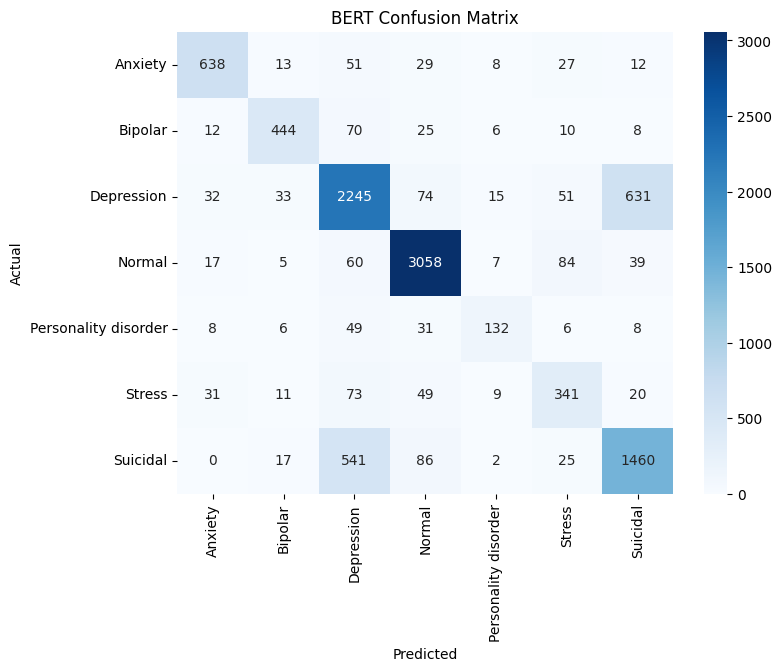

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_bert)
macro_f1 = f1_score(y_test, y_pred_bert, average='macro')
weighted_f1 = f1_score(y_test, y_pred_bert, average='weighted')
macro_precision = precision_score(y_test, y_pred_bert, average='macro', zero_division=0)
macro_recall = recall_score(y_test, y_pred_bert, average='macro', zero_division=0)
report = classification_report(y_test, y_pred_bert, output_dict=True, zero_division=0)

# Create a summary DataFrame
bert_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Macro Recall'],
    'Score': [accuracy, macro_f1, weighted_f1, macro_precision, macro_recall]
})

print("\nBERT Model Metrics:")
print(bert_metrics.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bert, labels=sorted(y_test.unique()))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.show()


In [ ]:
print("\n" + "="*50)
print("CALCULATING METRICS")
print("="*50)

# Calculate metrics for each model
metrics_list = []


# Tuned Linear SVM
metrics_svm_tuned = compute_comprehensive_metrics(y_test, y_pred_svm_tuned, "Tuned Linear SVM")
metrics_list.append(metrics_svm_tuned)

# BERT
metrics_bert = compute_comprehensive_metrics(y_test, y_pred_bert, "BERT Fine-tuned")
metrics_list.append(metrics_bert)

# Create comparison DataFrame
comparison_df = pd.DataFrame(metrics_list)
comparison_df = comparison_df[['Model', 'Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Macro Recall']]

print("\nCOMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


CALCULATING METRICS

COMPREHENSIVE MODEL COMPARISON
           Model  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
Tuned Linear SVM    0.7390    0.6828       0.7356           0.6718        0.6999
 BERT Fine-tuned    0.7841    0.7482       0.7836           0.7682        0.7328


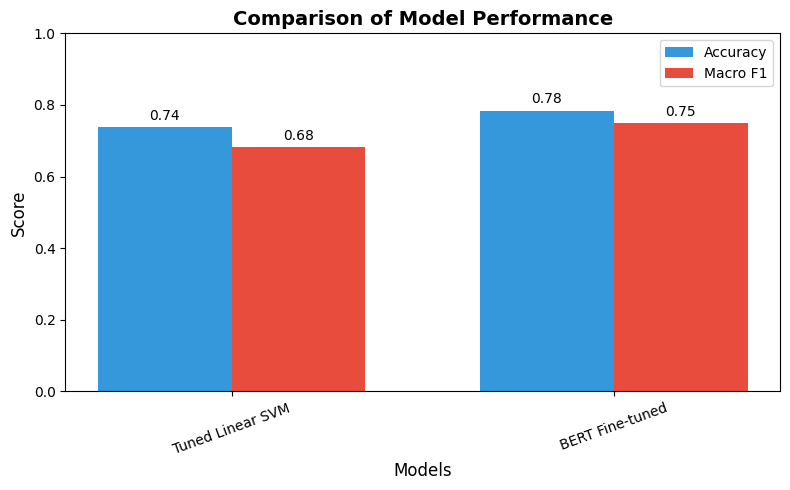

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select only the models you want
selected_models = ['Enhanced Logistic Regression', 'Tuned Linear SVM', 'BERT Fine-tuned']
comparison_subset = comparison_df[comparison_df['Model'].isin(selected_models)]

models = comparison_subset['Model'].values
accuracy = comparison_subset['Accuracy'].values
macro_f1 = comparison_subset['Macro F1'].values

# Set up the figure
plt.figure(figsize=(8,5))
bar_width = 0.35
index = np.arange(len(models))

# Accuracy bars
plt.bar(index, accuracy, bar_width, label='Accuracy', color='#3498db')
# Macro F1 bars
plt.bar(index + bar_width, macro_f1, bar_width, label='Macro F1', color='#e74c3c')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparison of Model Performance', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width/2, models, rotation=20)
plt.ylim(0, 1)
plt.legend()

# Display values on top of bars
for i in range(len(models)):
    plt.text(i, accuracy[i]+0.02, f"{accuracy[i]:.2f}", ha='center', fontsize=10)
    plt.text(i + bar_width, macro_f1[i]+0.02, f"{macro_f1[i]:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


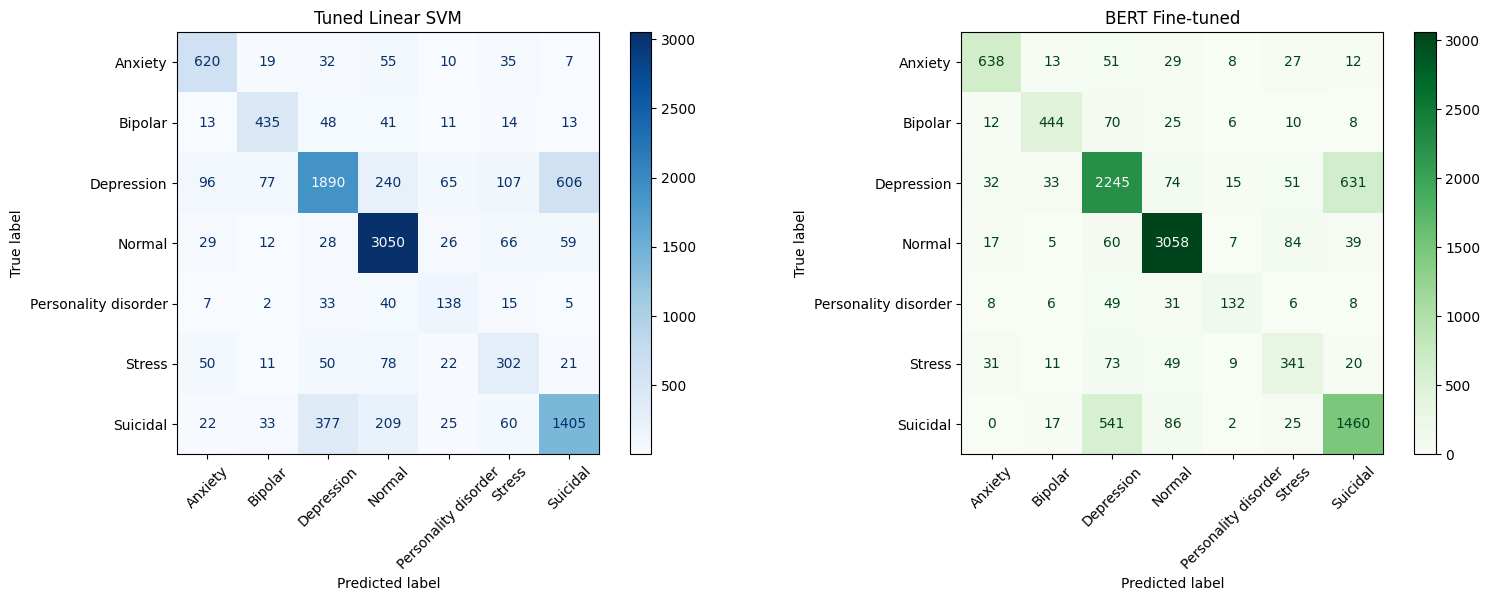

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get unique class labels (same order as in y_test)
labels = sorted(y_test.unique())

# Confusion matrix for Tuned Linear SVM
cm_svm = confusion_matrix(y_test, y_pred_svm_tuned, labels=labels)

# Confusion matrix for BERT
cm_bert = confusion_matrix(y_test, y_pred_bert, labels=labels)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Tuned Linear SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp_svm.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title("Tuned Linear SVM")

# BERT
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=labels)
disp_bert.plot(ax=axes[1], cmap='Greens', xticks_rotation=45)
axes[1].set_title("BERT Fine-tuned")

plt.tight_layout()
plt.show()


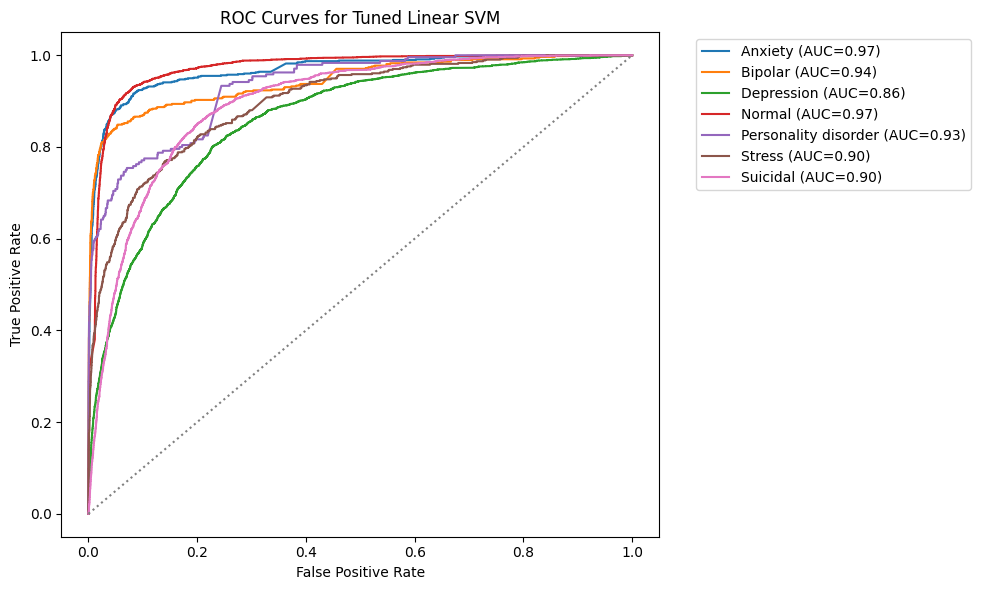

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


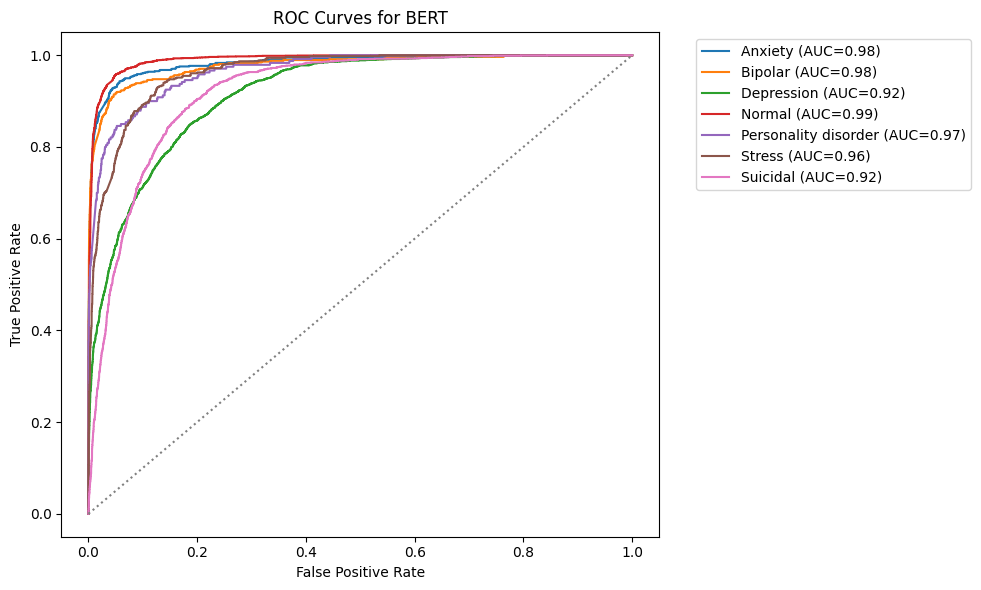

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
classes = sorted(y_test.unique())
n_classes = len(classes)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=classes)

# --- Tuned Linear SVM ---
y_score_svm = tuned_linear_svm.decision_function(X_test_enhanced)

plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_svm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Linear SVM')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- BERT ---
y_score_bert = []
for text in X_test:
    preds = bert_classifier(text, truncation=True, max_length=128, return_all_scores=True)[0]
    prob = [next((p['score'] for p in preds if p['label'] == c), 0) for c in classes]
    y_score_bert.append(prob)
y_score_bert = np.array(y_score_bert)

plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bert[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for BERT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [2]:
from sklearn.metrics import roc_auc_score

# Calculate macro ROC AUC for Tuned Linear SVM
roc_auc_svm = roc_auc_score(y_test_bin, y_score_svm, average='macro')
print(f"Macro ROC AUC Score - Tuned Linear SVM: {roc_auc_svm:.4f}")

# Calculate macro ROC AUC for BERT
roc_auc_bert = roc_auc_score(y_test_bin, y_score_bert, average='macro')
print(f"Macro ROC AUC Score - BERT: {roc_auc_bert:.4f}")

# Calculate micro ROC AUC for comparison
roc_auc_svm_micro = roc_auc_score(y_test_bin, y_score_svm, average='micro')
roc_auc_bert_micro = roc_auc_score(y_test_bin, y_score_bert, average='micro')
print(f"\nMicro ROC AUC Scores:")
print(f"Tuned Linear SVM: {roc_auc_svm_micro:.4f}")
print(f"BERT: {roc_auc_bert_micro:.4f}")

# Calculate weighted ROC AUC
roc_auc_svm_weighted = roc_auc_score(y_test_bin, y_score_svm, average='weighted')
roc_auc_bert_weighted = roc_auc_score(y_test_bin, y_score_bert, average='weighted')
print(f"\nWeighted ROC AUC Scores:")
print(f"Tuned Linear SVM: {roc_auc_svm_weighted:.4f}")
print(f"BERT: {roc_auc_bert_weighted:.4f}")

NameError: name 'y_test_bin' is not defined

In [ ]:
# Sample statements (you can edit or expand)
sample_texts = [
   # Normal
    "I had a great day today! Went for a walk and enjoyed the sunshine.",

    # Depression
    "I think my life is always sad.",

    # Suicidal
    "Sometimes I want to die",

    # Anxiety
    "I  worry and think a lot everytime",

    # Bipolar
    "I feel like no on has time for me and i dont have any friends"
    # Stress
    "I  feel liek i dont get even time for my studies and im always working.",

    # Personality Disorder
    "I often feel misunderstood by people and find it hard to maintain close relationships."
]

# 1. Tuned Linear SVM predictions
X_sample_tfidf = tfidf_enhanced.transform(sample_texts)
y_pred_svm_tuned_sample = tuned_linear_svm.predict(X_sample_tfidf)

# 2. BERT predictions
y_pred_bert_sample = []
y_pred_bert_probs = []

for text in sample_texts:
    result = bert_classifier(text, truncation=True, max_length=128)[0]
    y_pred_bert_sample.append(result['label'])
    y_pred_bert_probs.append(result['score'])

# Display results nicely
print("SAMPLE PREDICTIONS\n")
header = "{:<7} | {:<50} | {:<20} | {:<25}".format(
    "Example", "Text Preview", "Tuned SVM", "BERT Prediction (Confidence)"
)
print(header)
print("-" * len(header))

for i, text in enumerate(sample_texts):
    text_preview = text if len(text) <= 50 else text[:47] + "..."
    svm_pred = y_pred_svm_tuned_sample[i]
    bert_pred = f"{y_pred_bert_sample[i]} ({y_pred_bert_probs[i]:.2f})"
    row = "{:<7} | {:<50} | {:<20} | {:<25}".format(i+1, text_preview, svm_pred, bert_pred)
    print(row)


SAMPLE PREDICTIONS

Example | Text Preview                                       | Tuned SVM            | BERT Prediction (Confidence)
------------------------------------------------------------------------------------------------------------------
1       | I had a great day today! Went for a walk and en... | Normal               | Normal (1.00)            
2       | I think my life is always sad.                     | Normal               | Normal (0.86)            
3       | Sometimes I want to die                            | Suicidal             | Suicidal (0.55)          
4       | I  worry and think a lot everytime                 | Anxiety              | Anxiety (0.95)           
5       | I feel like no on has time for me and i dont ha... | Normal               | Suicidal (0.72)          
6       | I often feel misunderstood by people and find i... | Normal               | Personality disorder (0.34)


In [ ]:
# Select 5 sample statements from the test set
sample_idx = X_test.index[:5]

print("SAMPLE PREDICTIONS on Tuned Linear SVM\n")
print("Example | True Label       | Predicted (SVM)  | Text Preview")
print("-" * 90)

for i, idx in enumerate(sample_idx):
    text = X_test.loc[idx]  # Statement text
    true = y_test.loc[idx]  # True label
    pred_svm = y_pred_svm_tuned[i]  # Tuned SVM prediction
    correct = "✔" if true == pred_svm else "X"
    print(f"{i+1:7} | {true:16} | {pred_svm:16} {correct} | {text[:100]}...")
print("\n")

print("SAMPLE PREDICTIONS on BERT Fine-tuned\n")
print("Example | True Label       | Predicted (BERT)        | Confidence | Text Preview")
print("-" * 110)

for i, idx in enumerate(sample_idx):
    text = X_test.loc[idx]  # Statement text
    true = y_test.loc[idx]  # True label
    pred_bert = y_pred_bert[i]  # BERT predicted label
    confidence = y_pred_bert_probs[i]  # BERT confidence
    correct = "✔" if true == pred_bert else "X"
    print(f"{i+1:7} | {true:16} | {pred_bert:22} {correct} | {confidence:.2f}      | {text[:80]}...")


SAMPLE PREDICTIONS on Tuned Linear SVM

Example | True Label       | Predicted (SVM)  | Text Preview
------------------------------------------------------------------------------------------
      1 | Stress           | Depression       X | recently went event extremely traumatic without specifying recently everywhere news less week even s...
      2 | Normal           | Normal           ✔ | want rest win giveaway...
      3 | Suicidal         | Suicidal         ✔ | basically bro die gon feel pain put people thru kill gon suffer way going feel constant pain everyon...
      4 | Depression       | Depression       ✔ | today mark month since broke one single day wake thinking incredibly sorry thing went depression lac...
      5 | Normal           | Normal           ✔ | writing help sooth wound wondering people would willing read themhave story idea mostly write shorti...


SAMPLE PREDICTIONS on BERT Fine-tuned

Example | True Label       | Predicted (BERT)        | Confidence | Text Pr